# Couette Flow
### Introduction
Planar Couette flow is the flow of fluids with some viscosity $\nu$ beween two surfaces that are moving tangentially relative to one another. This relative motion induces flow due to the imposed shear stresses on the viscous fluid, otherwise known as shear-driven fluid motion. Assuming the surfaces are parallel, and the flow is fully developed, the Navier-Stokes equation simplifies to:

\begin{align}
    \frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial^2 y}
\end{align}

where the streamwise velocity has both spacial and temporal coordinates. In order to solve for $u(y, t)$, we have been given the following boundary conditions and initial condition:

\begin{align}
    u(0, t) &= 0 \\
    u(h, t) &= U \\
    u(y, 0) &= U\frac{y}{h} + U\sin{\frac{\pi y}{h}}
\end{align}

### Numerical Solution
Given a system of equations which can be solved by writing them in the form $Ax = b$, there are two ways to go about solving the PDE numerically: using the Thomas Algorithm, or just inverting the matrices $A$ that contain the coefficients applied to the vector $x$ which contain $u_{j}^{n+1}$ in order to solve for a vector $b$ which contains $u^{n}_j$. 

In [129]:
#imports and global variables
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

N = [11, 21, 41, 81] #number of distinct y-values
currN = N[1] #currently set N=21 for the sake of the required sample solution set to be submitted for homework
delta_t = [0.001, 0.003, 0.01, 0.03, 0.1] #time-step size
curr_dt = delta_t[1] #set dt = 0.003 for the sample solution set
eps = 10**(-6) #allowed tolerance in the round-off error

##### The Thomas Algorithm
We begin with the Thomas algorithm. This is a simplified Gaussian-elimination method, which can be used here since $A$ is tridiagonal. It is much more computationally efficient than manual matrix inversion. The implementation of the algorithm was borrowed from [this site](https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9).

In [130]:
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

##### Matrix Inversion
Alternatively, one can also use np.linalg.inv to compute the multiplicative inverse of a matrix. This solution is less stable, as will be examined later on.

In [131]:
#function for calculating u_{j+1} given some u{j}
def alt_u_iter(N, u_j, dt, dy):
    r = dt/(dy)**2
    M = np.zeros((N,N))
    for i in range(currN):
        M[i][i] = -(2*r + 1)
    for j in range(0,N-1):
        M[j][j+1] = r
        M[j+1][j] = r
    #Boundary conditions:
    M[0][0] = 1 #u(0,t)=0 
    M[N-1][N-1] = -1 #u(h,t)=1 
    M[0][1] = 0 #u(h,t)=0 
    M[N-1][N-2] = 0 #u(h,t)=1 
    return np.linalg.inv(M)@u_j

def inverse(N, dt, eps, prec = np.double):
    dy = 1/(N-1)
    yvals = np.linspace(0,1,N)
    uvals = np.asarray([yvals + np.sin(np.pi*yvals)], dtype = prec)
    exact_vals = np.asarray(uvals, dtype = prec)
    error_1 = np.asarray([0], dtype = prec)
    error_2 = np.asarray([np.sqrt(np.sum((uvals[0] - yvals)**2)/(N-2))], dtype = prec)
    
    i=0
    while (error_2[-1]>eps):
        next_u = np.asarray([alt_u_iter(N, uvals[i], dt, dy)], dtype = prec)
        exact = np.asarray(u_exact(yvals, dt*(i+1)), dtype = prec)
        err1 = np.sqrt(np.sum((next_u - exact)**2)/(N-2), dtype = prec)
        err2 = np.sqrt(np.sum((next_u - yvals)**2)/(N-2), dtype = prec)
                           
        uvals = np.vstack([uvals, next_u])
        exact_vals = np.vstack([exact_vals, exact])
        error_1 = np.append(error_1, err1)
        error_2 = np.append(error_2, err2)
        
        i+=1

    
    return yvals, uvals, exact_vals, error_1, error_2, i

##### The (Better) Numerical Solution
For the homework's submission guidelines, I will be submitting the answers generated by the following code and the $N = 21$ and $\Delta t = 0.003$ case with the Thomas Algorithm. Comparisons with direct matrix inversion will be made later on in the further analysis section.

In [132]:
#create matrices for the coette flow velocities
def u_exact(y, t):
    #exact solution for the error analysis 
    return y + np.exp(-(np.pi**2) * t) * np.sin(np.pi * y)

def u_iter(u_j, dt, dy):
    #given some velocity from the previous time step and r = dt/(dy)^2
    #generate the coefficient matrix
    r = dt / (dy**2)
    size = len(u_j)
    lowerTriangle = r * np.ones(size-1)
    lowerTriangle[-1] = 0 #u(h,t)=1 
    diagonal = -(2*r+1) * np.ones(size)
    diagonal[0] = 1 #u(0,t)=0 
    diagonal[-1] = -1 #u(h,t)=1 
    upperTriangle = r * np.ones(size)
    upperTriangle[0] = 0 #u(h,t)=0 
    
    #invert via Thomas algorithm to get the resulting vector containing u_{j+1}
    return TDMAsolver(lowerTriangle, diagonal, upperTriangle, -u_j)

def numSol(N, dt, eps, prec = np.double):
    #numerically calculates the velocities under Couette flow,
    #also calculates the errors in comparison to the known solution 
    #and the steady-state solution
    
    #generate the boundary conditions
    dy = 1/(N-1)
    yvals = np.linspace(0, 1, N)
    uvals = np.asarray([yvals + np.sin(np.pi*yvals)], dtype = prec)
    exactvals = np.asarray(uvals, dtype = prec)
    err1 = np.asarray([0], dtype = prec)
    err2 = np.asarray([np.sqrt(np.sum((uvals[0] - yvals)**2)/(N-2))], dtype = prec)

    
    #calculating the velocities and errors
    i=0
    while (err2[-1]>eps):
        next_u = np.asarray([u_iter(uvals[i], dt, dy)], dtype = prec)
        exact = np.asarray(u_exact(yvals, dt*(i+1)),dtype = prec)
        error1 = np.sqrt(np.sum((next_u - exact)**2)/(N-2), dtype = prec)
        error2 = np.sqrt(np.sum((next_u - yvals)**2)/(N-2), dtype = prec)
                           
        uvals = np.vstack([uvals, next_u])
        exactvals = np.vstack([exactvals, exact])
        err1 = np.append(err1, error1)
        err2 = np.append(err2, error2)
        
        i+=1

    
    return yvals, uvals, exactvals, err1, err2, i


### Writing to Files and Saving Data

In [133]:
#change the index on N and dt for different test confirgurations
yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(N[1], delta_t[1], eps, prec=np.double)

itrep = np.asarray([],dtype = int)
timeval = np.asarray([])
yrep = np.linspace(0,1,curr_N)
for j in range(0,num_iter):
    yrep = np.append(yrep, np.linspace(0,1,curr_N)) #y values corresponding to data points
for j in range(0,num_iter+1):
    itrep = np.append(itrep, j*np.ones(curr_N,dtype = int))
    timeval = np.append(timeval, (j*curr_dt)*np.ones(curr_N))


#create velocity data file
data = {
    'tstep_number' : itrep,
    'time': np.asarray(timeval,dtype = np.float16),
    'y_location' : np.asarray(yrep, dtype = np.float16),
    'numerical_sol' : uvals.flatten(),
    'exact_sol' : exact_vals.flatten()
}

#create error data file
errors = {
    'tstep_number' : np.arange(0,num_iter+1, 1, dtype =int),
    'time': np.asarray([n*curr_dt for n in range(0,num_iter+1)], np.float16),
    'error_1': error_1,
    'error_2' : error_2
}

#write data 
data_df = pd.DataFrame.from_dict(data)
error_df = pd.DataFrame.from_dict(errors)

#save data
data_df.to_csv('./couette_data_mq.txt', header=True, index=None, sep="|", mode='w')
error_df.to_csv('./couette_error_mq.txt', header=True, index=None, sep="|", mode='w')

### Testing with the N=21 and dt=0.003 case

In [134]:
data_df

,tstep_number,time,y_location,numerical_sol,exact_sol
0,0,0.000000,0.000000,0.000000,0.000000
1,0,0.000000,0.049988,0.206434,0.206434
2,0,0.000000,0.099976,0.409017,0.409017
3,0,0.000000,0.150024,0.603990,0.603990
4,0,0.000000,0.199951,0.787785,0.787785
...,...,...,...,...,...
9760,464,1.391602,0.799805,0.800001,0.800001
9761,464,1.391602,0.850098,0.850001,0.850000
9762,464,1.391602,0.899902,0.900000,0.900000
9763,464,1.391602,0.950195,0.950000,0.950000


In [135]:
error_df

,tstep_number,time,error_1,error_2
0,0,0.000000,0.000000e+00,7.254763e-01
1,1,0.003000,3.444633e-04,7.046551e-01
2,2,0.006001,6.689910e-04,6.844315e-01
3,3,0.009003,9.744482e-04,6.647884e-01
4,4,0.012001,1.261667e-03,6.457090e-01
...,...,...,...,...
460,460,1.379883,2.224823e-07,1.104564e-06
461,461,1.382812,2.165158e-07,1.072863e-06
462,462,1.385742,2.107084e-07,1.042072e-06
463,463,1.388672,2.050559e-07,1.012165e-06


### Comparison Using Straightforward Matrix Inversion

In [136]:
#Compare and store the empirical time complexity of the execution of the two methods
dt_list = np.linspace(0.001,0.05,100)
fast_times = []
slow_times = []
for dt in dt_list:
    startf = time.time()
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(currN, dt, 
                                                                        eps, prec=np.double)
    endf = time.time()
    fast_times.append(endf-startf)
    
    starts = time.time()
    yvals, uvals, exact_vals, error_1, error_2, num_iter = inverse(currN, dt, 
                                                                        eps, prec=np.double)
    ends = time.time()
    slow_times.append(ends-starts)

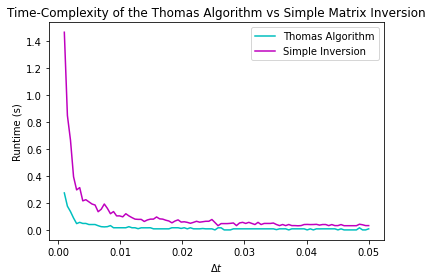

In [137]:
plt.title('Time-Complexity of the Thomas Algorithm vs Simple Matrix Inversion')
plt.xlabel('$\Delta t$')
plt.ylabel('Runtime (s)')
plt.plot(dt_list, fast_times, color = 'c', label = 'Thomas Algorithm')
plt.plot(dt_list, slow_times, color = 'm', label = 'Simple Inversion')
plt.savefig('./figures/time_complexity_mq.pdf', format='pdf')
plt.legend()
plt.show()

### Error Analysis
#### Error at Different Resolutions

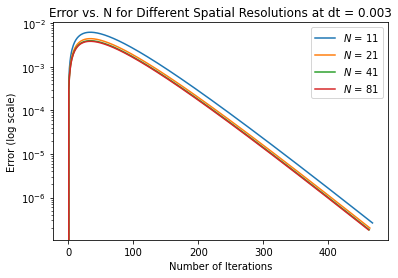

In [138]:
#Uses root mean squared method (error 1) to go through different N
#(holding dt = 0.003) and then different dt (holding N = 21)
for n in N:
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(n, 
                                                            curr_dt, eps, prec=np.double)
    xdata = np.arange(0,num_iter+1, 1)
    ydata = error_1
    plt.plot(xdata, ydata, label = '$N$ = '+str(n))

plt.title('Error vs. N for Different Spatial Resolutions at dt = 0.003')
plt.xlabel('Number of Iterations')
plt.yscale('log')
plt.ylabel('Error (log scale)')
plt.legend()
plt.savefig('./figures/spatial_errors_mq.pdf', format='pdf')
plt.show()

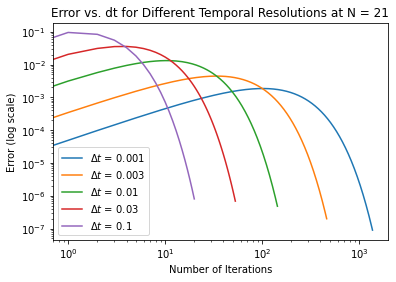

In [139]:
for dt in delta_t:
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(currN, dt, 
                                                                eps, prec=np.double)
    xdata = np.arange(0,num_iter+1, 1)
    ydata = error_1
    plt.plot(xdata, ydata, label = '$\Delta t$ = '+str(dt))
    
plt.title('Error vs. dt for Different Temporal Resolutions at N = 21')
plt.xlabel('Number of Iterations')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error (log scale)')
plt.legend()
plt.savefig('./figures/temporal_errors_mq.pdf', format='pdf')
plt.show()

#### Convergence to the Steady-State Solution

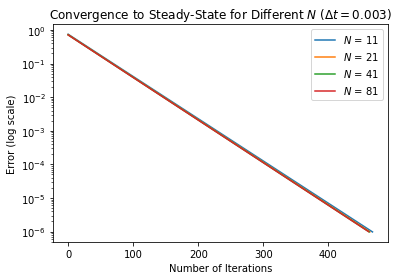

In [140]:
#use Error 2 to find how close we are to the steady state solution
#vary N and then vary dt, in similar fashion as above
for n in N:
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(n, curr_dt, 
                                                                  eps, prec=np.double)
    xdata = np.arange(0,num_iter+1, 1)
    ydata = error_2
    plt.plot(xdata, ydata, label = '$N$ = '+str(n))

plt.title('Convergence to Steady-State for Different $N$ ($\Delta t = 0.003$)')
plt.xlabel('Number of Iterations')
plt.yscale('log')
plt.ylabel('Error (log scale)')
plt.legend()
plt.savefig('./figures/spatial_convergence_mq.pdf', format='pdf')
plt.show()

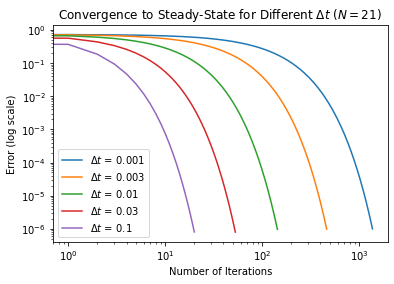

In [141]:
for dt in delta_t:
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(currN, dt, 
                                                                eps, prec=np.double)
    xdata = np.arange(0,num_iter+1, 1)
    ydata = error_2
    plt.plot(xdata, ydata, label = '$\Delta t$ = '+str(dt))
    
plt.title('Convergence to Steady-State for Different $\Delta t$ ($N = 21$)')
plt.xlabel('Number of Iterations')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error (log scale)')
plt.legend()
plt.savefig('./figures/temporal_convergence_mq.pdf', format='pdf')
plt.show()

#### Convergence Under Different $\epsilon$
Below is a repeat of the spatial and temporal convergence analyses under different tolerance levels in the round-off error $\epsilon$

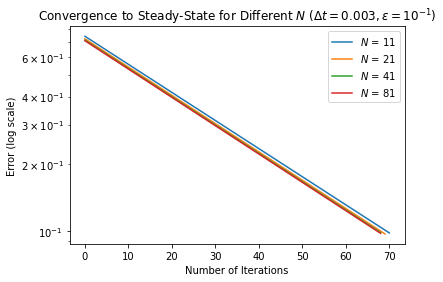

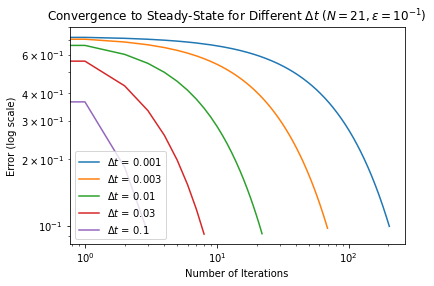

In [142]:
new_eps = eps*(10**5) #sets epsilon = 10^(-5)
#vary N:
plt.figure(1)
for n in N:
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(n, curr_dt, 
                                                                  new_eps, prec=np.double)
    xdata = np.arange(0,num_iter+1, 1)
    ydata = error_2
    plt.plot(xdata, ydata, label = '$N$ = '+str(n))

plt.title('Convergence to Steady-State for Different $N$ ($\Delta t = 0.003, \epsilon = 10^{-1}$)')
plt.xlabel('Number of Iterations')
plt.yscale('log')
plt.ylabel('Error (log scale)')
plt.legend()
plt.savefig('./figures/spatial_convergence_bigE.pdf', format='pdf')
plt.show()

#vary dt:
plt.figure(2)
for dt in delta_t:
    yvals, uvals, exact_vals, error_1, error_2, num_iter = numSol(currN, dt, 
                                                                new_eps, prec=np.double)
    xdata = np.arange(0,num_iter+1, 1)
    ydata = error_2
    plt.plot(xdata, ydata, label = '$\Delta t$ = '+str(dt))
    
plt.title('Convergence to Steady-State for Different $\Delta t$ ($N = 21, \epsilon = 10^{-1}$)')
plt.xlabel('Number of Iterations')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Error (log scale)')
plt.legend()
plt.savefig('./figures/temporal_convergence_bigE.pdf', format='pdf')
plt.show()
